# Dogs breed classifier

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# Install required packages 
!pip3 install smdebug --no-cache-dir


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# Install required packages 
!pip3 install jinja2==3.0.3 --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 212.5 MB/s eta 0:00:00
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 3.1.2
    Uninstalling Jinja2-3.1.2:
      Successfully uninstalled Jinja2-3.1.2

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [4]:
#Install required packages for deployment
!pip3 install torch torchvision --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 189.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 216.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 143.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 215.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 222.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 294.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
#!pip3 install plotly --no-cache-dir

In [7]:
# Import required packages
import os
import sagemaker
import boto3

# Required packages for Hyperparameter tuning
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

# Required packages for training and deployment
from sagemaker.pytorch import (
    PyTorch, 
    PyTorchModel
)

# Required packages for debugging and profiling
from sagemaker.debugger import (
    Rule,
    ProfilerRule,
    DebuggerHookConfig,
    rule_configs,
    ProfilerConfig, 
    FrameworkProfile,
    CollectionConfig
)

# Required packages for debugger and profiler output analysis
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

# Required for Profiler Report
import IPython

## 1. Dataset
The dataset being used contains RGB images of dogs belonging to 133 different breeds. It contains a total number of 8352 images. Approximately 80% of the images are provided for training and the remaining 20% are equally split for validation and testing purpose.

In [ ]:
#Fetch and upload the data to AWS S3

# Command to download and unzip data (This command needs to be executed once)
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [8]:
#Set Sagemaker variables
session = sagemaker.Session()
bucket = session.default_bucket()
role = sagemaker.get_execution_role()

In [9]:
#Ensure Sagemaker variable values are correctly set
print("Default Bucket: {}".format(bucket))
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-678784019262
RoleArn: arn:aws:iam::678784019262:role/service-role/AmazonSageMaker-ExecutionRole-20230223T072359


In [10]:
#Define the path to which the images are to be uploaded in S3
prefix = "project-3/data/dog-images"

In [ ]:
#Command to Upload data to S3 (This command needs to be executed once)
inputs = session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)
print("input spec (in this case, just an S3 path): {}".format(inputs))

In [11]:
#Set S3 path containing the dataset for further runs
inputs = "s3://sagemaker-us-east-1-678784019262/project-3/data/dog-images"

## 2. Hyperparameter Tuning
Attempting to find the best possible values for learning rate, batch size and epochs to be executed for training a good dog images classifier. From experience these values seems to have the capacity to drastically impact the predictive power of the model.

Using the `hpo.py` script to perform hyperparameter tuning.

In [ ]:
#Declare the HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size" : CategoricalParameter([128, 256, 512]),
    "epochs" : IntegerParameter(7, 10)
}

In [ ]:
#Create estimators for Hyperparameters (HP)
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version="py36",
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.xlarge"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=4,
    #max_runtime_in_seconds=2400,
    objective_type=objective_type,
    early_stopping_type="Auto"
)

In [ ]:
# Perform HP tuning
tuner.fit({"train": inputs+"/train/", 
"valid": inputs+"/valid/",
"test": inputs+"/test/"
})

In [12]:
# Attach the best, previously completed training job (Execute when need to save AWS credits and avoid rerun)
tuner = HyperparameterTuner.attach("pytorch-training-230227-1141")

In [13]:
# Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()
print(f"Best estimator is: {best_estimator._current_job_name}")

# Get the hyperparameters of the best trained model
best_hp = best_estimator.hyperparameters()

# Print the best hyperparameters
print(f"Best hyperparameters are: {best_hp}")


2023-02-27 12:20:08 Starting - Preparing the instances for training
2023-02-27 12:20:08 Downloading - Downloading input data
2023-02-27 12:20:08 Training - Training image download completed. Training in progress.
2023-02-27 12:20:08 Uploading - Uploading generated training model
2023-02-27 12:20:08 Completed - Resource released due to keep alive period expiry
Best estimator is: pytorch-training-230227-1141-002-e5ebfecc
Best hyperparameters are: {'_tuning_objective_metric': '"average test loss"', 'batch-size': '"128"', 'epochs': '9', 'lr': '0.00711527529031811', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"pytorch-training-2023-02-27-11-41-06-534"', 'sagemaker_program': '"hpo.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-678784019262/pytorch-training-2023-02-27-11-41-06-534/source/sourcedir.tar.gz"'}


In [14]:
# Save the best identified values into best_hyperparameters variable
best_hyperparameters = {
    "batch-size": int(best_hp["batch-size"].replace('"', "")),
    "epochs": best_hp["epochs"],
    "lr": best_hp["lr"]
}

## 3. Model Profiling and Debugging
Using the best hyperparameters, creating and finetuning a new model.

Using the `train_model.py` script to perform model profiling and debugging while finetuning the model to detect any issues in performance or training early on.

In [16]:
# Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

# Make sure to set this to your bucket and location
BUCKET_NAME = bucket
LOCATION_IN_BUCKET = "project-3/dogBreed-tensor-plot"
s3_bucket_for_tensors = "s3://{BUCKET_NAME}/{LOCATION_IN_BUCKET}".format(
    BUCKET_NAME=BUCKET_NAME, LOCATION_IN_BUCKET=LOCATION_IN_BUCKET
)

hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "10", "eval.save_interval": "1", "predict.save_interval": "1"},
    s3_output_path=s3_bucket_for_tensors,  # Required
    collection_configs=[
            CollectionConfig(
                name="CrossEntropyLoss_output", parameters={"include_regex": "CrossEntropyLoss_output.*", 
                                                            "train.save_interval": "10", 
                                                            "eval.save_interval": "1",
                                                            "predict.save_interval": "1"}
            )
        ]        
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

In [17]:
# Create and fit an estimator
estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="sagemaker-script-mode",
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    hyperparameters=best_hyperparameters,
    framework_version="1.8",
    py_version="py36",
    ## Debugger parameters
    rules=rules,
    debugger_hook_config=hook_config,
    ## Profiler parameters
    profiler_config=profiler_config
)

In [18]:
estimator.fit({"train": inputs+"/train/", 
"valid": inputs+"/valid/",
"test": inputs+"/test/"
})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: sagemaker-script-mode-2023-03-05-22-53-42-252


2023-03-05 22:53:43 Starting - Starting the training job...
2023-03-05 22:54:10 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-03-05 22:55:11 Downloading - Downloading input data......
2023-03-05 22:56:11 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-05 22:56:04,072 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-05 22:56:04,075 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-05 22:56:04,085 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-05 22:56:04,087 sagemaker_pytorch_container.training INFO     

In [ ]:
# Attach the latest training job (Execute when need to save AWS credits and avoid rerun)
#estimator = PyTorch.attach("sagemaker-script-mode-2023-03-02-10-44-31-991")

In [19]:
# Plot a debugging output
tensors_path = estimator.latest_job_debugger_artifacts_path()
print(f"tensors path is: {tensors_path}")
trial = create_trial(tensors_path)

print(f"Tensor names are: {trial.collections}")
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

tensors path is: s3://sagemaker-us-east-1-678784019262/project-3/dogBreed-tensor-plot/sagemaker-script-mode-2023-03-05-22-53-42-252/debug-output
[2023-03-05 23:36:09.636 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:95 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-678784019262/project-3/dogBreed-tensor-plot/sagemaker-script-mode-2023-03-05-22-53-42-252/debug-output
[2023-03-05 23:36:12.554 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:95 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-03-05 23:36:13.575 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:95 INFO trial.py:210] Loaded all steps
Tensor names are: <bound method Trial.collections of <smdebug.trials.s3_trial.S3Trial object at 0x7f0e67db2c50>:(
    name=debug-output,
    path=s3://sagemaker-us-east-1-678784019262/project-3/dogBreed-tensor-plot/sagemaker-script-mode-2023-03-05-22-53-42-252/debug-output/,
    steps=[0, 10, 20, 30

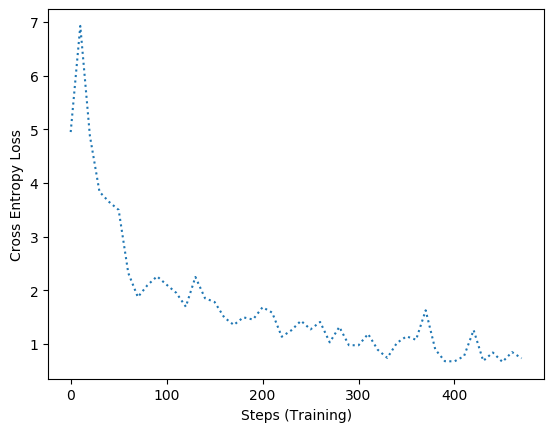

In [20]:
# Plot a debugging output
import matplotlib.pyplot as plt
import numpy as np

dict_train_loss = trial.tensor("CrossEntropyLoss_output_0").values(mode=ModeKeys.TRAIN)
dict_test_loss = trial.tensor("CrossEntropyLoss_output_0").values(mode=ModeKeys.EVAL)

train_loss_steps = list(dict_train_loss.keys())
train_loss_values = list(dict_train_loss.values())

plt.plot(train_loss_steps, train_loss_values, linestyle = 'dotted')
plt.xlabel("Steps (Training)")  # add X-axis label
plt.ylabel("Cross Entropy Loss")  # add Y-axis label
plt.show()

In [ ]:
import os

# Download Tensor from S3
folder_name = tensors_path.split("/")[-1]
os.system("aws s3 cp --recursive " + tensors_path + " " + folder_name)
print("Downloaded tensors into folder: ", folder_name)

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [21]:
# Ensure Profiler data from system is available
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
training_job_name = estimator.latest_training_job.name
#region = bucket.get_bucket_location()
region = 'us-east-1'
print(region)
tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

us-east-1
ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-678784019262/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-678784019262/sagemaker-script-mode-2023-03-05-22-53-42-252/profiler-output


Profiler data from system is available


In [22]:
#Display the profiler output
system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2023-03-05 23:36:50.558 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:95 INFO metrics_reader_base.py:134] Getting 41 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1'}


In [23]:
#Preparing to display the profiler report
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

You will find the profiler report in s3://sagemaker-us-east-1-678784019262/sagemaker-script-mode-2023-03-05-22-53-42-252/rule-output


In [ ]:
#Display the profiler report

IPython.display.HTML("./profilerReport/profiler-report.html")

## Model Deploying

In [ ]:
# installing these as they'll be needed for inference
!pip3 install torch torchvision --no-cache-dir

In [24]:
#Preparing for model deployment
# estimator = PyTorch.attach("sagemaker-script-mode-2023-02-24-08-49-57-557")

model_data = estimator.output_path + estimator.latest_training_job.job_name + "/output/model.tar.gz"
print(f"Model: {model_data}")

Model: s3://sagemaker-us-east-1-678784019262/sagemaker-script-mode-2023-03-05-22-53-42-252/output/model.tar.gz


In [ ]:
# Deploy your model to an endpoint
# predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

In [25]:
from sagemaker.pytorch.model import PyTorchModel
# Add Model Loader
model = PyTorchModel(
    entry_point="inference.py",
    role=role,
    model_data=model_data,
    framework_version="1.8",
    py_version="py36",
)

# Deploy
predictor = model.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

INFO:sagemaker:Creating model with name: pytorch-inference-2023-03-05-23-37-41-230
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-03-05-23-37-41-963
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-03-05-23-37-41-963


---------!

## Testing Deployment

In [ ]:
# installing these as they'll be needed for inference
!pip3 install torch torchvision --no-cache-dir

In [26]:
# Run an prediction on the endpoint
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

In [27]:
predictor = sagemaker.pytorch.model.PyTorchPredictor("pytorch-inference-2023-03-05-23-37-41-963")

In [28]:
# TODO: Predict function that takes in an image, preprocesses it, and uses the endpoint for prediction
def predict(image_path):
    image = Image.open(image_path)

    transform = transforms.Compose([
            transforms.Resize((100, 100)),
            transforms.ToTensor(),
        ])

    preprocessed_image = transform(image).unsqueeze(0)
    preprocessed_image = preprocessed_image.to("cpu")

    response = predictor.predict(preprocessed_image)
    pred = np.argmax(response, 1)
    plt.imshow(Image.open(image_path))
    plt.show()
    print(f"Actual: {image_path[15:18]}, Prediction: {pred[0]}")

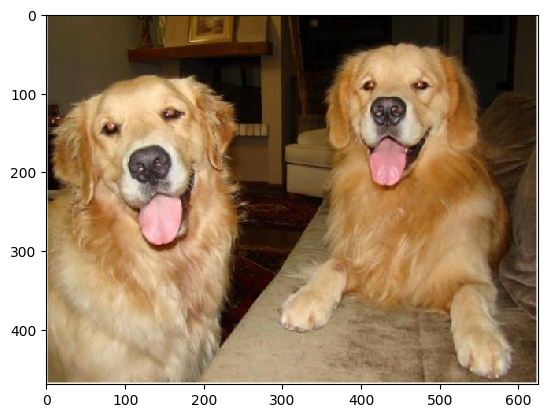

Actual: 076, Prediction: 50


In [39]:
image_path = "dogImages/test/076.Golden_retriever/Golden_retriever_05250.jpg"
predict(image_path)

In [41]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-03-05-23-37-41-963
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-03-05-23-37-41-963


In [40]:
print(image_path[:])

dogImages/test/076.Golden_retriever/Golden_retriever_05250.jpg
